<center><h1>The Battle of the Neighborhoods</h1></center>

# Table of Contents

2.  <a href="#item1">Introduction: Business Problem</a>
3.  <a href="#item2">Data sources</a>  
4.  <a href="#item3">Data extraction</a>  
5.  <a href="#item4">Institutes visualization and Data</a>  
6.  <a href="#item6">Preproccesing steps: one hot encoding</a>  
7.  <a href="#item7">Methodology: K-means</a>  
8.  <a href="#item8">Results</a>  
9.  <a href="#item9">Discussion</a>  
10. <a href="#item10">Conclusion</a>  

# Intoduction: Business Problem

**Background** Nowadays, there is a substantial increment of remote work due to the fact that the society is going through a pandemic. A lot of companies have offered the possibility to their employees to work from home (mainly). However, some employees could have had the idea of taking this opportunity to keep working for their employers but from other locations where in some way, could represent a better quality of life, or better personal or professional satisfaction. 

People in Latin America that have enough level of incomes could have thought that this new way of working can be a opportunity to move to another country (where english is the official language) to learn a new language. A perfect combination has arised because those people could re locate to another country without the risk of losing their jobs.

**Problem** The question now is how a person that wants to learn english and is looking to move to a english spoken country can find the best option?
Over the internet, there are a lot of courses offered in different cities, so, the main purpose of this exercise is finding the best one taking into account the variety of venues around the course location as a decisor. 

**It is important to aclare that this exercise assumes that the closer the housing to the course location the better for the "new student".**

# Data sources

**Where do we find the data?**

The two main data sources are:

+ Web scraping
+ Foursquare API

The exercise is made for people who is looking to move to Canada or United States so, the website that is used to scrape the data of the courses will only be for USA and Canada. 

***Only the best 15 courses for each country according to the website will be considered***

The URL for the courses in **Canada**: <a>https://www.languageinternational.com/english-courses-canada</a>

The URL for the courses in **United States**: <a>https://www.languageinternational.com/english-courses-usa</a>

If we look at the web sites, the main page does not have the addresses of the institutes, so, the first task is finding their addresses within the website. 

**How it will be used?**

Once all the addresses are saved in the dataframe of the courses (the structure of the dataframe will be **institutename, city, name, address, postalcode**), the next step is finding the coordinates of each institute.

After having all the neccesary data of the courses with their specific addresses the next step is use Foursquare as the provider of the venues around specific locations (through the API) 

**Note:** the locations that are going to be used in the API are the institue ones. 

# Data extraction

**Let's import necessary Libraries**

In [2]:
# This section is used to import libraries that are going to be used along the project

!pip install bs4
from bs4 import BeautifulSoup # this module helps in web scrapping.

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import re # library for regular expressions

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge plotly
#import plotly.express as px
#import plotly.graph_objects as go

# import k-means from clustering stage
from sklearn.cluster import KMeans

from IPython.display import Image

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


**Now it's time to start doing the web scraping to obtain the addresses of the institutes**

The first url to scrape is for the courses of Canada

In [3]:
urlcanada="https://www.languageinternational.com/english-courses-canada"

html_data_canada  = requests.get(urlcanada).text
soup_canada = BeautifulSoup(html_data_canada,"html5lib")

Let's create a dataframe where the scraped data is going to be stored.

**The dataframe will have 6 columns**

In [4]:
df_courses = pd.DataFrame(columns=["Location", "CourseName", "InstituteName", "PriceFrom", "PriceTo", "Address", "urlcourse", "urlinstitute", "latitude", "longitude", "Country"])

All the data that we need is inside the div section with the class: **row gutterh-xs**

In [5]:
for div in soup_canada.find_all('div',class_='row gutterh-xs'): 
        
    location = div.find_all(attrs={'class': 'searchresult_subh'})[0].text   
    coursename = div.find_all(itemprop='name')[0].text
    institutename = div.find_all(itemprop='name')[1].text
    pricefrom = div.find_all(attrs={'class': 'courselist_course_prices_box_amount'})[0].text 
    priceto = div.find_all(attrs={'class': 'courselist_course_prices_box_amount'})[1].text
    
    url = div.find_all('a', href=True)[0]
    
    df_courses = df_courses.append({"Location":location, "CourseName":coursename, "InstituteName":institutename, "PriceFrom":pricefrom, "PriceTo":priceto, "urlcourse":url['href'], "Country": "Canada"}, ignore_index=True)                    

The columns that contains prices need to be cleaned. 

* Regex patters are used to replace some strings present in both columns

In [6]:
df_courses[['PriceFrom','PriceTo']] = df_courses[['PriceFrom','PriceTo']].replace(to_replace=["\t|\n|\r", "\W"], value=["", ""], regex=True)

Here the result of the web scraping from the url for the courses in Canada

In [7]:
df_courses.head()

,Location,CourseName,InstituteName,PriceFrom,PriceTo,Address,urlcourse,urlinstitute,latitude,longitude,Country
0,"Calgary, Canada",General English 20 (GE20),ANNE'S Language House,354,687,NaN,/course/general-english-20-ge20-anne-s-languag...,NaN,NaN,NaN,Canada
1,"Hamilton, Canada",ESL Private Lessons,Metropolitan College,384,619,NaN,/course/esl-private-lessons-metropolitan-colle...,NaN,NaN,NaN,Canada
2,"Calgary, Canada",General English (GE25),ANNE'S Language House,384,717,NaN,/course/general-english-ge25-anne-s-language-h...,NaN,NaN,NaN,Canada
3,"Hamilton, Canada",Intensive English,Metropolitan College,290,525,NaN,/course/intensive-english-metropolitan-college...,NaN,NaN,NaN,Canada
4,"Vancouver, Canada",General 20,Language Studies International (LSI): Vancouver,431,759,NaN,/course/general-20-language-studies-internatio...,NaN,NaN,NaN,Canada


Now, let's do exactly the same but for the courses that are offered in the United States

In [8]:
urlusa="https://www.languageinternational.com/english-courses-usa"

html_data_usa  = requests.get(urlusa).text
soup_usa = BeautifulSoup(html_data_usa,"html5lib")

In [9]:
for div in soup_usa.find_all('div',class_='row gutterh-xs'): 
        
    location = div.find_all(attrs={'class': 'searchresult_subh'})[0].text   
    coursename = div.find_all(itemprop='name')[0].text
    institutename = div.find_all(itemprop='name')[1].text
    pricefrom = div.find_all(attrs={'class': 'courselist_course_prices_box_amount'})[0].text 
    priceto = div.find_all(attrs={'class': 'courselist_course_prices_box_amount'})[1].text
    
    url = div.find_all('a', href=True)[0]
    
    
    df_courses = df_courses.append({"Location":location, "CourseName":coursename, "InstituteName":institutename, "PriceFrom":pricefrom, "PriceTo":priceto, "urlcourse":url['href'], "Country":"USA"}, ignore_index=True)       

In [10]:
df_courses[['PriceFrom','PriceTo']] = df_courses[['PriceFrom','PriceTo']].replace(to_replace=["\t|\n|\r", "\W"], value=["", ""], regex=True)

**Now we have the dataframe with the data of Canada and United States courses**

In [11]:
df_courses

,Location,CourseName,InstituteName,PriceFrom,PriceTo,Address,urlcourse,urlinstitute,latitude,longitude,Country
0,"Calgary, Canada",General English 20 (GE20),ANNE'S Language House,354,687,NaN,/course/general-english-20-ge20-anne-s-languag...,NaN,NaN,NaN,Canada
1,"Hamilton, Canada",ESL Private Lessons,Metropolitan College,384,619,NaN,/course/esl-private-lessons-metropolitan-colle...,NaN,NaN,NaN,Canada
2,"Calgary, Canada",General English (GE25),ANNE'S Language House,384,717,NaN,/course/general-english-ge25-anne-s-language-h...,NaN,NaN,NaN,Canada
3,"Hamilton, Canada",Intensive English,Metropolitan College,290,525,NaN,/course/intensive-english-metropolitan-college...,NaN,NaN,NaN,Canada
4,"Vancouver, Canada",General 20,Language Studies International (LSI): Vancouver,431,759,NaN,/course/general-20-language-studies-internatio...,NaN,NaN,NaN,Canada
5,"Toronto, Canada",Intensive 30,Language Studies International (LSI): Toronto,495,823,NaN,/course/intensive-30-language-studies-internat...,NaN,NaN,NaN,Canada
6,"Vancouver, Canada",Intensive 30,Language Studies International (LSI): Vancouver,495,823,NaN,/course/intensive-30-language-studies-internat...,NaN,NaN,NaN,Canada
7,"Toronto, Canada",General 20,Language Studies International (LSI): Toronto,431,759,NaN,/course/general-20-language-studies-internatio...,NaN,NaN,NaN,Canada
8,"Vancouver, Canada",Intensive 25,Language Studies International (LSI): Vancouver,465,794,NaN,/course/intensive-25-language-studies-internat...,NaN,NaN,NaN,Canada
9,"Toronto, Canada",Club 40+ (20 lessons per week plus afternoon a...,Language Studies International (LSI): Toronto,708,1037,NaN,/course/club-40-20-lessons-per-week-plus-after...,NaN,NaN,NaN,Canada


The column **Address** and **urlInstitue** as you can see, have **NaN** values because the address and the url of the institute is not present in the scraped url. 

The address can be found once the course is selected. A new page needs to be scraped for each one of the courses present in the dataframe

The url format to scrape data related to the course for all the rows is <a>https://www.languageinternational.com/xxxxxxxxxx</a>

Where ***xxxxxxxxxx*** will be replaced with the **urlcourse column** to scrape the address and url of the institute of each course

**Note:** the url of the institute is scraped because the data of the latitude and longitude is already present in the web site in the page of the institutes

In [12]:
for index, row in df_courses.iterrows():
      
    urlcourse="https://www.languageinternational.com" + row['urlcourse']
    html_data_course  = requests.get(urlcourse).text
    soup_course = BeautifulSoup(html_data_course,"html5lib")

    for div in soup_course.find_all(attrs={'class': 'school_upper'}):  
        df_courses.iloc[index]['Address'] = div.find_all('span')[0].text
        print('Address: {} '.format(div.find_all('span')[0].text))
        
        for div in soup_course.find_all(attrs={'class': 'pageheader_text'}):
            df_courses.iloc[index]['urlinstitute'] = div.find_all('a', href=True)[0]['href']
            print('url of institue: {} '.format(div.find_all('a', href=True)[0]['href']))
            print('--- Added to dataframe ---')

print('----------------')    
print('--End of update-')

Address: 101 6th Avenue S.W., Suite 1250, Calgary, Alberta, AB T2P3P4, Canada 
url of institue: /school/anne-s-language-house-64694 
--- Added to dataframe ---
Address: 146 James Street South, Hamilton, Ontario,, Hamilton, Ontario L8P 3A2, Canada 
url of institue: /school/metropolitan-college-64750 
--- Added to dataframe ---
Address: 101 6th Avenue S.W., Suite 1250, Calgary, Alberta, AB T2P3P4, Canada 
url of institue: /school/anne-s-language-house-64694 
--- Added to dataframe ---
Address: 146 James Street South, Hamilton, Ontario,, Hamilton, Ontario L8P 3A2, Canada 
url of institue: /school/metropolitan-college-64750 
--- Added to dataframe ---
Address: 101-808 Nelson Street, Vancouver, BC V6Z 2H2, Canada 
url of institue: /school/language-studies-international-lsi-vancouver-18606 
--- Added to dataframe ---
Address: 1055 Yonge Street, Suite #210, Toronto, ON M4W 2L2, Canada 
url of institue: /school/language-studies-international-lsi-toronto-18605 
--- Added to dataframe ---
Addres

In [13]:
df_courses.head()

,Location,CourseName,InstituteName,PriceFrom,PriceTo,Address,urlcourse,urlinstitute,latitude,longitude,Country
0,"Calgary, Canada",General English 20 (GE20),ANNE'S Language House,354,687,"101 6th Avenue S.W., Suite 1250, Calgary, Albe...",/course/general-english-20-ge20-anne-s-languag...,/school/anne-s-language-house-64694,NaN,NaN,Canada
1,"Hamilton, Canada",ESL Private Lessons,Metropolitan College,384,619,"146 James Street South, Hamilton, Ontario,, Ha...",/course/esl-private-lessons-metropolitan-colle...,/school/metropolitan-college-64750,NaN,NaN,Canada
2,"Calgary, Canada",General English (GE25),ANNE'S Language House,384,717,"101 6th Avenue S.W., Suite 1250, Calgary, Albe...",/course/general-english-ge25-anne-s-language-h...,/school/anne-s-language-house-64694,NaN,NaN,Canada
3,"Hamilton, Canada",Intensive English,Metropolitan College,290,525,"146 James Street South, Hamilton, Ontario,, Ha...",/course/intensive-english-metropolitan-college...,/school/metropolitan-college-64750,NaN,NaN,Canada
4,"Vancouver, Canada",General 20,Language Studies International (LSI): Vancouver,431,759,"101-808 Nelson Street, Vancouver, BC V6Z 2H2, ...",/course/general-20-language-studies-internatio...,/school/language-studies-international-lsi-van...,NaN,NaN,Canada


At this point, in the dataframe, the columns *address* and *urlinstitute* are already filled up with the scraped data

With this data ready, we can proceed to get the coordinates from the website as well. The coordinates will be added to the dataframe

**Note:** in this step, a regular expression is used to extract a portion of the entire text where the coordinates are

In [14]:
for index, row in df_courses.iterrows():
    urlinstitute="https://www.languageinternational.com" + row['urlinstitute']
    html_data_institute  = requests.get(urlinstitute).text

    # Create a pattern to match names
    pattern = re.compile(r'(?=latitude)(.*)(?=url)', flags = re.M)
    # Find all occurrences of the pattern
    result = pattern.findall(html_data_institute)
    # Let's clean the text matched
    mapping = {'latitude':'', 'longitude':'', '"':'', ':':''}
    for k, v in mapping.items():
        result[0] = result[0].replace(k, v)

    # Now, a split is used to assign latitude and longitude variables    
    latitude = result[0].split(',')[0]
    df_courses.iloc[index]['latitude'] = result[0].split(',')[0]
    
    longitude = result[0].split(',')[1]
    df_courses.iloc[index]['longitude'] = result[0].split(',')[1]

    print(latitude, longitude)
    print('--- Lat and Lon added ---')
    
print('----------------')    
print('--End of update-')

51.04715 -114.06334
--- Lat and Lon added ---
43.25243 -79.8713
--- Lat and Lon added ---
51.04715 -114.06334
--- Lat and Lon added ---
43.25243 -79.8713
--- Lat and Lon added ---
49.28004 -123.12491
--- Lat and Lon added ---
43.67851 -79.38973
--- Lat and Lon added ---
49.28004 -123.12491
--- Lat and Lon added ---
43.67851 -79.38973
--- Lat and Lon added ---
49.28004 -123.12491
--- Lat and Lon added ---
43.67851 -79.38973
--- Lat and Lon added ---
43.67851 -79.38973
--- Lat and Lon added ---
49.28004 -123.12491
--- Lat and Lon added ---
49.28004 -123.12491
--- Lat and Lon added ---
49.28836 -123.12259
--- Lat and Lon added ---
45.466221 -74.077549
--- Lat and Lon added ---
32.78098 -117.09628
--- Lat and Lon added ---
32.85252 -117.18622
--- Lat and Lon added ---
32.80372 -117.21411
--- Lat and Lon added ---
32.85252 -117.18622
--- Lat and Lon added ---
32.78098 -117.09628
--- Lat and Lon added ---
33.90986 -117.85417
--- Lat and Lon added ---
42.35072 -71.05826
--- Lat and Lon added 

**The dataframe now is complete!**

In [15]:
df_courses.head()

,Location,CourseName,InstituteName,PriceFrom,PriceTo,Address,urlcourse,urlinstitute,latitude,longitude,Country
0,"Calgary, Canada",General English 20 (GE20),ANNE'S Language House,354,687,"101 6th Avenue S.W., Suite 1250, Calgary, Albe...",/course/general-english-20-ge20-anne-s-languag...,/school/anne-s-language-house-64694,51.04715,-114.06334,Canada
1,"Hamilton, Canada",ESL Private Lessons,Metropolitan College,384,619,"146 James Street South, Hamilton, Ontario,, Ha...",/course/esl-private-lessons-metropolitan-colle...,/school/metropolitan-college-64750,43.25243,-79.8713,Canada
2,"Calgary, Canada",General English (GE25),ANNE'S Language House,384,717,"101 6th Avenue S.W., Suite 1250, Calgary, Albe...",/course/general-english-ge25-anne-s-language-h...,/school/anne-s-language-house-64694,51.04715,-114.06334,Canada
3,"Hamilton, Canada",Intensive English,Metropolitan College,290,525,"146 James Street South, Hamilton, Ontario,, Ha...",/course/intensive-english-metropolitan-college...,/school/metropolitan-college-64750,43.25243,-79.8713,Canada
4,"Vancouver, Canada",General 20,Language Studies International (LSI): Vancouver,431,759,"101-808 Nelson Street, Vancouver, BC V6Z 2H2, ...",/course/general-20-language-studies-internatio...,/school/language-studies-international-lsi-van...,49.28004,-123.12491,Canada


# Institutes visualization and Data

Looking at the data, it is suitable to have a child dataframe with the institutes with their respectives coordinates to avoid duplicates. This happens because it can be that a institute can offer more than one course.

In [16]:
df_institutes = df_courses[['InstituteName','latitude','longitude', 'Country']].drop_duplicates(subset=['InstituteName','latitude','longitude', 'Country'], keep='last').reset_index()
df_institutes

,index,InstituteName,latitude,longitude,Country
0,2,ANNE'S Language House,51.04715,-114.06334,Canada
1,3,Metropolitan College,43.25243,-79.8713,Canada
2,10,Language Studies International (LSI): Toronto,43.67851,-79.38973,Canada
3,12,Language Studies International (LSI): Vancouver,49.28004,-123.12491,Canada
4,13,International Language Academy of Canada Vanco...,49.28836,-123.12259,Canada
5,14,Bouchereau Lingua International,45.466221,-74.077549,Canada
6,17,Connect English Language Institute- San Diego ...,32.80372,-117.21411,USA
7,18,Connect English- La Jolla,32.85252,-117.18622,USA
8,19,Connect English Language Institute- Mission Va...,32.78098,-117.09628,USA
9,20,American English Language School,33.90986,-117.85417,USA


In [17]:
df_institutes["latitude"] = df_institutes["latitude"].astype("float")
df_institutes["longitude"] = df_institutes["longitude"].astype("float")

print(df_institutes.dtypes)

index              int64
InstituteName     object
latitude         float64
longitude        float64
Country           object
dtype: object


In [18]:
print('--> We can observe now that there are ', df_institutes.shape[0], ' different institutes that offer the best 30 courses in Canada and United States <--') 

--> We can observe now that there are  13  different institutes that offer the best 30 courses in Canada and United States <--


In [19]:
bar_data = df_institutes.groupby(['Country'])['InstituteName'].count().reset_index()
bar_data

,Country,InstituteName
0,Canada,6
1,USA,7


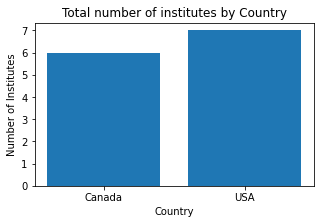

Done!


In [20]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(bar_data['Country'],bar_data['InstituteName'])

ax.set_xlabel('Country')
ax.set_ylabel('Number of Institutes')

plt.title('Total number of institutes by Country')
plt.show()
print('Done!')

Let's get the geographical coordinates of North America.

In [21]:
address = 'North America'

geolocator = Nominatim(user_agent="northamerica_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of North America are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North America are 51.0000002, -109.0.


**Create a map of North America with the institutes superimposed on top**

In [54]:
courses_map = folium.Map(location=[latitude, longitude], zoom_start=4)

for lat, lng, institute, country in zip(df_institutes['latitude'], df_institutes['longitude'], df_institutes['InstituteName'], df_institutes['Country']):
    label = institute
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(courses_map)  
    
# display map    
courses_map
#Image(filename='mapInstitutes.png')

**Define Foursquare Credentials and Version**

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [24]:
CLIENT_ID = 'IJFZ0DC4A2GVGVYMK0QCF413Q114Y1GSJX3KP0T44C4C3JGI' # your Foursquare ID
CLIENT_SECRET = 'E50AREFRWDXT1FY3SAYQJZEAGNX4S4VUTI01N4WNELI4HF3J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IJFZ0DC4A2GVGVYMK0QCF413Q114Y1GSJX3KP0T44C4C3JGI
CLIENT_SECRET:E50AREFRWDXT1FY3SAYQJZEAGNX4S4VUTI01N4WNELI4HF3J


**Let's create a function to get the data from the venues of the entire list of institutes**

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['InstituteName', 
                  'InstituteLatitude', 
                  'InstituteLongitude',
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

**Let's run the above function on each institute and create a new dataframe called institutes_venues**

In [26]:
# type your answer here
institutes_venues = getNearbyVenues(names=df_institutes['InstituteName'],
                                   latitudes=df_institutes['latitude'],
                                   longitudes=df_institutes['longitude']
                                  )

ANNE'S Language House
Metropolitan College
Language Studies International (LSI): Toronto
Language Studies International (LSI): Vancouver
International Language Academy of Canada Vancouver
Bouchereau Lingua International
Connect English Language Institute- San Diego (Pacific Beach Campus)
Connect English- La Jolla
Connect English Language Institute- Mission Valley
American English Language School
Language Studies International (LSI): Boston
Language Studies International (LSI): New York
Language Studies International (LSI): San Diego


**Let's check the size of the resulting dataframe**

In [27]:
print(institutes_venues.shape)
institutes_venues.head()

(515, 7)


,InstituteName,InstituteLatitude,InstituteLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory
0,ANNE'S Language House,51.04715,-114.06334,The Palomino Smokehouse,51.046435,-114.063410,American Restaurant
1,ANNE'S Language House,51.04715,-114.06334,Blink,51.045422,-114.063733,Restaurant
2,ANNE'S Language House,51.04715,-114.06334,Phil & Sebastian Coffee Roasters,51.045619,-114.063324,Coffee Shop
3,ANNE'S Language House,51.04715,-114.06334,Over Easy Breakfast,51.048561,-114.065917,Breakfast Spot
4,ANNE'S Language House,51.04715,-114.06334,Hyatt Regency Calgary,51.046373,-114.062583,Hotel


Let's check how many venues were returned for each institute

In [58]:
print(institutes_venues.groupby('InstituteName')['InstituteName'].count())

InstituteName
ANNE'S Language House                                                    41
American English Language School                                         21
Bouchereau Lingua International                                           5
Connect English Language Institute- Mission Valley                       16
Connect English Language Institute- San Diego (Pacific Beach Campus)     13
Connect English- La Jolla                                                 6
International Language Academy of Canada Vancouver                       45
Language Studies International (LSI): Boston                             82
Language Studies International (LSI): New York                          100
Language Studies International (LSI): San Diego                          23
Language Studies International (LSI): Toronto                            42
Language Studies International (LSI): Vancouver                          89
Metropolitan College                                                     3

**Let's find out how many unique categories can be curated from all the returned venues**

In [33]:
print('There are {} uniques categories.'.format(len(institutes_venues['VenueCategory'].unique())))

There are 151 uniques categories.


# Preproccesing steps: one hot encoding

In [34]:
institutes_onehot = pd.get_dummies(institutes_venues[['VenueCategory']], prefix="", prefix_sep="")

# add institute column back to dataframe
institutes_onehot['InstituteName'] = institutes_venues['InstituteName'] 

# move InstituteName column to the first column
fixed_columns = [institutes_onehot.columns[-1]] + list(institutes_onehot.columns[:-1])
institutes_onehot = institutes_onehot[fixed_columns]

institutes_onehot.head()

,InstituteName,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,BBQ Joint,Bakery,...,Toy / Game Store,Train Station,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,ANNE'S Language House,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ANNE'S Language House,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ANNE'S Language House,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ANNE'S Language House,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ANNE'S Language House,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Next, let's group rows by institute and by taking the mean of the frequency of occurrence of each category**

In [35]:
institutes_grouped = institutes_onehot.groupby('InstituteName').mean().reset_index()
institutes_grouped

,InstituteName,Accessories Store,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,BBQ Joint,Bakery,...,Toy / Game Store,Train Station,Tree,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,ANNE'S Language House,0.00,0.048780,0.024390,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.024390,0.000000,0.00000,0.000000,0.000000,0.000000
1,American English Language School,0.00,0.047619,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.047619,0.047619
2,Bouchereau Lingua International,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,Connect English Language Institute- Mission Va...,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.0625,0.00000,0.000000,...,0.000000,0.0625,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,Connect English Language Institute- San Diego ...,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,Connect English- La Jolla,0.00,0.000000,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,International Language Academy of Canada Vanco...,0.00,0.066667,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.022222,...,0.000000,0.0000,0.00,0.00000,0.000000,0.022222,0.00000,0.000000,0.000000,0.000000
7,Language Studies International (LSI): Boston,0.00,0.024390,0.000000,0.060976,0.00000,0.00,0.0000,0.00000,0.097561,...,0.000000,0.0000,0.00,0.02439,0.012195,0.000000,0.00000,0.000000,0.000000,0.012195
8,Language Studies International (LSI): New York,0.01,0.020000,0.000000,0.000000,0.00000,0.01,0.0000,0.01000,0.000000,...,0.000000,0.0000,0.01,0.00000,0.000000,0.000000,0.00000,0.030000,0.020000,0.000000
9,Language Studies International (LSI): San Diego,0.00,0.043478,0.000000,0.000000,0.00000,0.00,0.0000,0.00000,0.000000,...,0.000000,0.0000,0.00,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


**Let's print each institute along with the top 5 most common venues**

In [36]:
num_top_venues = 5

for institute in institutes_grouped['InstituteName']:
    print("----"+institute+"----")
    temp = institutes_grouped[institutes_grouped['InstituteName'] == institute].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANNE'S Language House----
                   venue  freq
0             Restaurant  0.12
1                  Hotel  0.10
2  Performing Arts Venue  0.07
3             Steakhouse  0.05
4            Coffee Shop  0.05


----American English Language School----
          venue  freq
0   Coffee Shop  0.10
1   Yoga Studio  0.05
2  Burger Joint  0.05
3    Food Truck  0.05
4   Gas Station  0.05


----Bouchereau Lingua International----
                        venue  freq
0                Home Service   0.2
1                       Diner   0.2
2              Chocolate Shop   0.2
3                 Supermarket   0.2
4  Construction & Landscaping   0.2


----Connect English Language Institute- Mission Valley----
                   venue  freq
0                    Pub  0.06
1    Martial Arts School  0.06
2            Flower Shop  0.06
3  Performing Arts Venue  0.06
4    Rental Car Location  0.06


----Connect English Language Institute- San Diego (Pacific Beach Campus)----
               venue  fre

**Let's put that into a _pandas_ dataframe**

First, let's write a function to sort the venues in descending order.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [38]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['InstituteName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
institutes_venues_sorted = pd.DataFrame(columns=columns)
institutes_venues_sorted['InstituteName'] = institutes_grouped['InstituteName']

for ind in np.arange(institutes_grouped.shape[0]):
    institutes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(institutes_grouped.iloc[ind, :], num_top_venues)

institutes_venues_sorted

,InstituteName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ANNE'S Language House,Restaurant,Hotel,Performing Arts Venue,Coffee Shop,Theater
1,American English Language School,Coffee Shop,Yoga Studio,Gym / Fitness Center,Food Truck,Gas Station
2,Bouchereau Lingua International,Diner,Home Service,Supermarket,Chocolate Shop,Construction & Landscaping
3,Connect English Language Institute- Mission Va...,Martial Arts School,Gym,Climbing Gym,Clothing Store,Rental Car Location
4,Connect English Language Institute- San Diego ...,Convenience Store,Hotel,Intersection,Thai Restaurant,Marijuana Dispensary
5,Connect English- La Jolla,Park,Scenic Lookout,Sporting Goods Shop,Golf Course,Flower Shop
6,International Language Academy of Canada Vanco...,Hotel,Restaurant,American Restaurant,Cosmetics Shop,Steakhouse
7,Language Studies International (LSI): Boston,Bakery,Chinese Restaurant,Asian Restaurant,Coffee Shop,Food Truck
8,Language Studies International (LSI): New York,Park,Pizza Place,Coffee Shop,Memorial Site,Hotel
9,Language Studies International (LSI): San Diego,Hotel,Park,Spa,Boutique,Deli / Bodega


# Methodology: K-means

Run _k_-means to cluster the institutes into clusters.

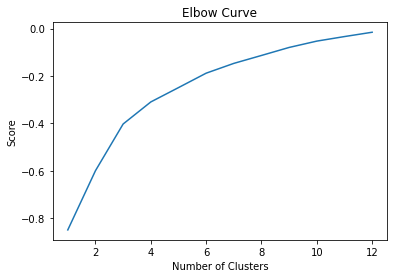

In [39]:
# Create range of K values

X = institutes_grouped_clustering = institutes_grouped.drop('InstituteName', 1)

Nc = range(1, 13)

#Create instances
kmeans = [KMeans(n_clusters=i, n_init = 12) for i in Nc]

#Fit the model and get scores for different K values
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

#Plot the Elbow curve
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [40]:
# Let's select k as 3 because is where an elbow can be identified in the above graph
kclusters = 3

institutes_grouped_clustering = institutes_grouped.drop('InstituteName', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(institutes_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 2, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each institute.

In [44]:
# add clustering labels
institutes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

institutes_merged = df_institutes

# merge institutes_grouped with manhattan_data to add latitude/longitude for each neighborhood
institutes_merged = institutes_merged.join(institutes_venues_sorted.set_index('InstituteName'), on='InstituteName')

institutes_merged.drop(['index'], axis=1, inplace=True) # check the last columns!
institutes_merged

,InstituteName,latitude,longitude,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ANNE'S Language House,51.047150,-114.063340,Canada,0,Restaurant,Hotel,Performing Arts Venue,Coffee Shop,Theater
1,Metropolitan College,43.252430,-79.871300,Canada,0,Pub,Coffee Shop,Sandwich Place,Italian Restaurant,Park
2,Language Studies International (LSI): Toronto,43.678510,-79.389730,Canada,0,Italian Restaurant,Coffee Shop,Park,Spa,Café
3,Language Studies International (LSI): Vancouver,49.280040,-123.124910,Canada,0,Hotel,Bakery,Japanese Restaurant,Mexican Restaurant,French Restaurant
4,International Language Academy of Canada Vanco...,49.288360,-123.122590,Canada,0,Hotel,Restaurant,American Restaurant,Cosmetics Shop,Steakhouse
5,Bouchereau Lingua International,45.466221,-74.077549,Canada,1,Diner,Home Service,Supermarket,Chocolate Shop,Construction & Landscaping
6,Connect English Language Institute- San Diego ...,32.803720,-117.214110,USA,0,Convenience Store,Hotel,Intersection,Thai Restaurant,Marijuana Dispensary
7,Connect English- La Jolla,32.852520,-117.186220,USA,2,Park,Scenic Lookout,Sporting Goods Shop,Golf Course,Flower Shop
8,Connect English Language Institute- Mission Va...,32.780980,-117.096280,USA,0,Martial Arts School,Gym,Climbing Gym,Clothing Store,Rental Car Location
9,American English Language School,33.909860,-117.854170,USA,0,Coffee Shop,Yoga Studio,Gym / Fitness Center,Food Truck,Gas Station


Finally, let's visualize the resulting clusters

In [59]:
institutes_merged["latitude"] = institutes_merged["latitude"].astype("float")
institutes_merged["longitude"] = institutes_merged["longitude"].astype("float")

In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(institutes_merged['latitude'], institutes_merged['longitude'], institutes_merged['InstituteName'], institutes_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
#Image(filename='mapClusters.png')

# Results

Now, is possible to examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [61]:
institutes_merged.loc[institutes_merged['Cluster Labels'] == 0, institutes_merged.columns[[1] + list(range(5, institutes_merged.shape[1]))]]

,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,51.04715,Restaurant,Hotel,Performing Arts Venue,Coffee Shop,Theater
1,43.25243,Pub,Coffee Shop,Sandwich Place,Italian Restaurant,Park
2,43.67851,Italian Restaurant,Coffee Shop,Park,Spa,Café
3,49.28004,Hotel,Bakery,Japanese Restaurant,Mexican Restaurant,French Restaurant
4,49.28836,Hotel,Restaurant,American Restaurant,Cosmetics Shop,Steakhouse
6,32.80372,Convenience Store,Hotel,Intersection,Thai Restaurant,Marijuana Dispensary
8,32.78098,Martial Arts School,Gym,Climbing Gym,Clothing Store,Rental Car Location
9,33.90986,Coffee Shop,Yoga Studio,Gym / Fitness Center,Food Truck,Gas Station
10,42.35072,Bakery,Chinese Restaurant,Asian Restaurant,Coffee Shop,Food Truck
11,40.70863,Park,Pizza Place,Coffee Shop,Memorial Site,Hotel


In [48]:
institutes_merged.loc[institutes_merged['Cluster Labels'] == 1, institutes_merged.columns[[1] + list(range(5, institutes_merged.shape[1]))]]

,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,45.466221,Diner,Home Service,Supermarket,Chocolate Shop,Construction & Landscaping


In [49]:
institutes_merged.loc[institutes_merged['Cluster Labels'] == 2, institutes_merged.columns[[1] + list(range(5, institutes_merged.shape[1]))]]

,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,32.85252,Park,Scenic Lookout,Sporting Goods Shop,Golf Course,Flower Shop


The 3 clusters according to the most common categories of venues for each group could be classified as:

| Name         | Cluster | 
| ------------------ | ------- | 
| LEISURE, STUDENTS, TOURISTS                | 0 |
| FAMILIAR      | 1 | 
| NATURE LOVERS                | 2 |


Now that each institute has its own cluster, would be great to have the information about the courses that the institutes offers with their respective prices 

This would help in some way to decide which course could be the best fit taking into account the venues, type of course and prices. The decision is up to the "new student"

In [50]:
institutes_all = df_courses.drop(columns=['latitude', 'longitude', 'Country', 'urlcourse', 'urlinstitute']) # Let's drop some columns because they are present in the table that is going to be merged with

institutes_all = institutes_merged.join(institutes_all.set_index('InstituteName'), on='InstituteName').drop(columns=['latitude', 'longitude']).reset_index().drop(columns=['index']) # Here is where the merge is done

institutes_all['PriceTo']=np.where(institutes_all['PriceTo']=='None',institutes_all['PriceFrom'], institutes_all['PriceTo']) # Let¿s replace the none values of the PriceTo column with the PriceFrom column


In [51]:
institutes_all["PriceTo"] = institutes_all["PriceTo"].astype("float")
institutes_all["PriceFrom"] = institutes_all["PriceFrom"].astype("float")

institutes_all

,InstituteName,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Location,CourseName,PriceFrom,PriceTo,Address
0,ANNE'S Language House,Canada,0,Restaurant,Hotel,Performing Arts Venue,Coffee Shop,Theater,"Calgary, Canada",General English 20 (GE20),354.0,687.0,"101 6th Avenue S.W., Suite 1250, Calgary, Albe..."
1,ANNE'S Language House,Canada,0,Restaurant,Hotel,Performing Arts Venue,Coffee Shop,Theater,"Calgary, Canada",General English (GE25),384.0,717.0,"101 6th Avenue S.W., Suite 1250, Calgary, Albe..."
2,Metropolitan College,Canada,0,Pub,Coffee Shop,Sandwich Place,Italian Restaurant,Park,"Hamilton, Canada",ESL Private Lessons,384.0,619.0,"146 James Street South, Hamilton, Ontario,, Ha..."
3,Metropolitan College,Canada,0,Pub,Coffee Shop,Sandwich Place,Italian Restaurant,Park,"Hamilton, Canada",Intensive English,290.0,525.0,"146 James Street South, Hamilton, Ontario,, Ha..."
4,Language Studies International (LSI): Toronto,Canada,0,Italian Restaurant,Coffee Shop,Park,Spa,Café,"Toronto, Canada",Intensive 30,495.0,823.0,"1055 Yonge Street, Suite #210, Toronto, ON M4W..."
5,Language Studies International (LSI): Toronto,Canada,0,Italian Restaurant,Coffee Shop,Park,Spa,Café,"Toronto, Canada",General 20,431.0,759.0,"1055 Yonge Street, Suite #210, Toronto, ON M4W..."
6,Language Studies International (LSI): Toronto,Canada,0,Italian Restaurant,Coffee Shop,Park,Spa,Café,"Toronto, Canada",Club 40+ (20 lessons per week plus afternoon a...,708.0,1037.0,"1055 Yonge Street, Suite #210, Toronto, ON M4W..."
7,Language Studies International (LSI): Toronto,Canada,0,Italian Restaurant,Coffee Shop,Park,Spa,Café,"Toronto, Canada",Afternoon 10,286.0,614.0,"1055 Yonge Street, Suite #210, Toronto, ON M4W..."
8,Language Studies International (LSI): Vancouver,Canada,0,Hotel,Bakery,Japanese Restaurant,Mexican Restaurant,French Restaurant,"Vancouver, Canada",General 20,431.0,759.0,"101-808 Nelson Street, Vancouver, BC V6Z 2H2, ..."
9,Language Studies International (LSI): Vancouver,Canada,0,Hotel,Bakery,Japanese Restaurant,Mexican Restaurant,French Restaurant,"Vancouver, Canada",Intensive 30,495.0,823.0,"101-808 Nelson Street, Vancouver, BC V6Z 2H2, ..."


**Let's calculate the average price from and to and the general as well**

In [52]:
institutes_prices = institutes_all.groupby(['InstituteName'])['Cluster Labels', 'PriceFrom', 'PriceTo'].mean().reset_index() #Let's calculate the mean of the prices by column
institutes_prices['PriceAvg'] = (institutes_prices['PriceFrom'] + institutes_prices['PriceTo']) / 2 #Let's calculate the mean of the prices by row

institutes_prices = institutes_prices.sort_values('PriceAvg', ascending=False).reset_index(drop=True)

institutes_prices['Cluster Labels'] = np.where(institutes_prices['Cluster Labels'] == 0,'LEISURE, STUDENTS, TOURISTS', np.where(institutes_prices['Cluster Labels'] == 1,'FAMILIAR', 'NATURE LOVERS'))

institutes_prices

<ipython-input-52-a505625daf17>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  institutes_prices = institutes_all.groupby(['InstituteName'])['Cluster Labels', 'PriceFrom', 'PriceTo'].mean().reset_index() #Let's calculate the mean of the prices by column


,InstituteName,Cluster Labels,PriceFrom,PriceTo,PriceAvg
0,Language Studies International (LSI): New York,"LEISURE, STUDENTS, TOURISTS",1505.000000,1830.000000,1667.500
1,Language Studies International (LSI): San Diego,"LEISURE, STUDENTS, TOURISTS",673.333333,1041.666667,857.500
2,Language Studies International (LSI): Boston,"LEISURE, STUDENTS, TOURISTS",648.750000,963.750000,806.250
3,Bouchereau Lingua International,FAMILIAR,533.000000,887.000000,710.000
4,International Language Academy of Canada Vanco...,"LEISURE, STUDENTS, TOURISTS",503.000000,870.000000,686.500
5,Language Studies International (LSI): Toronto,"LEISURE, STUDENTS, TOURISTS",480.000000,808.250000,644.125
6,Language Studies International (LSI): Vancouver,"LEISURE, STUDENTS, TOURISTS",477.000000,805.400000,641.200
7,ANNE'S Language House,"LEISURE, STUDENTS, TOURISTS",369.000000,702.000000,535.500
8,Metropolitan College,"LEISURE, STUDENTS, TOURISTS",337.000000,572.000000,454.500
9,Connect English Language Institute- San Diego ...,"LEISURE, STUDENTS, TOURISTS",390.000000,390.000000,390.000


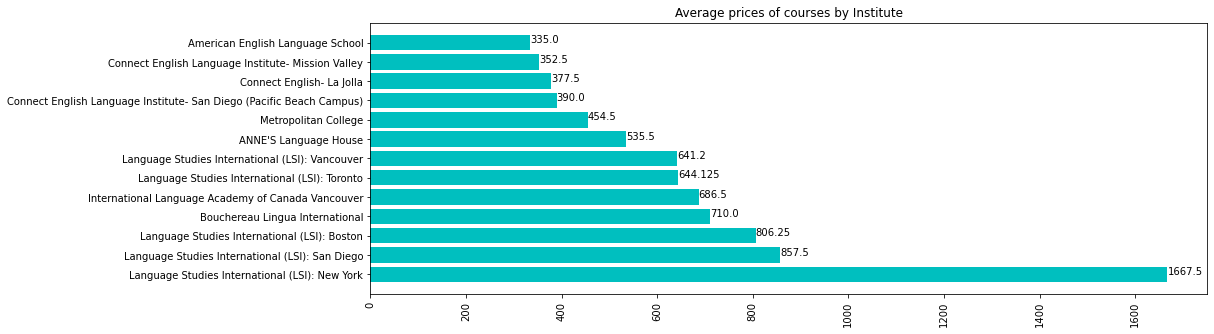

Done!


In [53]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.title('Average prices of courses by Institute')
plt.xticks(rotation=90)

ax.barh(institutes_prices['InstituteName'],institutes_prices['PriceAvg'], color=['c'])

for index, value in enumerate(institutes_prices['PriceAvg']):
    plt.text(value, index, str(value))
    
plt.show()
print('Done!')

# Discussion

This analysis shows that from the 30 courses selected from Canada and USA,  13 institutes are offering them in different locations of the countries. The locations are actually quite far one from each other (except for San Diego, USA where 4 courses are relatively closer). In this sense, takes a lot of importance the decision of selecting which course to take according to the personal "taste"

The venues around the institutes, after getting the data from the Foursquare API, **151** unique categories were identified. It is good to know that the radius that was selected for the API was 500 meters that is a distance considerably closer from the institutes.

The point here is that there are only 3 clusters created and one of them has the majority of institutes. After looking at the categories of the venues from each cluster, the possible classification can be:

+ LEISURE, STUDENTS, TOURISTS
+ FAMILIAR
+ NATURE LOVERS

The variety of categories of venues around the main one **LEISURE, STUDENTS, TOURISTS** let us assume that the public could be really diverse whereas in the other clusters, a more specific "taste" is found. It means, that for people for example that is thinking to travel with their families or that likes a lot the nature could be quite easier to take a decision. However, it is good to highlight that according to the locations of the institutes, there is a big opportunity of improvement of this model in terms of adding different variables that includes for example weather, temperature or cost of living. I would say that this is just a general idea of what to expect around the locations of study. 

Finally, the costs should be taken into account because the average of the courses are between 335 USD and 1667 USD which let us think that other variables such as reviews, ratings, comments or duration would be great to include to have an explanation of why the prices are so diverse. 

# Conclusion

This can be the first approach and as it is stated above, there is some additional information that can be useful to allow the "new student" to take a better decision. The good point here, is that, we already have a general view of the courses offered by the best institues according to the wbesite <a>https://www.languageinternational.com/</a> clustered by the categories of venues found around them.